# Really good training pipeline for pytorch EfficientDet 

Hi everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

Recently I have created kernel for this competition about Weighted Boxes Fusion:
- [WBF approach for ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)


I hope it is useful for you, my friends! If you didn't read this kernel, don't forget to do it! :)


Today I would like to share really good training pipeline for this competition using SOTA [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/pdf/1911.09070.pdf)

## Main Idea
 
I read [all public kernels about EfficientDet in kaggle community](https://www.kaggle.com/search?q=efficientdet+in%3Anotebooks) and understand that kaggle don't have really good working public kernels with good score. Why? You can see below picture about COCO AP for different architectures, I think everyone should be able to use such a strong tools EfficientDet for own research, lets do it!

<img src='https://miro.medium.com/max/2400/0*ApAKUWtseHcvRV2U.png' width=400>   



## Dependencies and imports

In this kernel used github repos [efficientdet-pytorch](https://github.com/rwightman/efficientdet-pytorch) and [pytorch-image-models](https://github.com/rwightman/pytorch-image-models) by [@rwightman](https://www.kaggle.com/rwightman). Don't forget add stars ;)

# EfficientDet, CV, 
[TODO](nagae): 交差分割した5つの学習データと検証データのセットで学習を行う。 mixupによる学習を入れる。

[NOTE](nagae): データ水増し部分、CVの切り方を変えてみる,EfficientDetのネットワークサイズを変える。　　

[EfficientDetの論文まとめ](https://qiita.com/omiita/items/83643f78baabfa210ab1)  
[mixup参考カーネル](https://www.kaggle.com/shonenkov/oof-evaluation-mixup-efficientdet)  


In [5]:
import torch

ModuleNotFoundError: No module named 'torch'

In [2]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

ERROR: pycocotools-2.0-cp37-cp37m-linux_x86_64.whl is not a supported wheel on this platform.


In [8]:
import sys

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

sys.path.append("../input/timm-efficientdet-pytorch/")
sys.path.append("../input/omegaconf/")

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from logging import getLogger, Formatter, FileHandler, StreamHandler, INFO, DEBUG


SEED = 42


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [9]:
def create_logger(exp_version):
    log_file = ("{}.log".format(exp_version))

    # logger
    logger_ = getLogger(exp_version)
    logger_.setLevel(DEBUG)

    # formatter
    fmr = Formatter("[%(levelname)s] %(asctime)s >>%(message)s")

    # file handler
    fh = FileHandler(log_file)
    fh.setLevel(DEBUG)
    fh.setFormatter(fmr)

    # stream handler
    ch = StreamHandler()
    ch.setLevel(INFO)
    ch.setFormatter(fmr)

    logger_.addHandler(fh)
    logger_.addHandler(ch)

    return logger_

def get_logger(exp_version):
    return getLogger(exp_version)


In [10]:
VERSION = "effdet-mixup-cutmix-cv" # 実験番号
logger = create_logger(VERSION)

In [11]:
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

print(marking)
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
print(bboxs)
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
marking['area'] = marking['w'] * marking['h']
marking = marking[marking['area'] < 100000]
logger.info(marking.head())

         image_id  width  height                         bbox     source
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1
...           ...    ...     ...                          ...        ...
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2

[147793 rows x 5 columns]


[INFO] 2020-07-24 16:10:06,668 >>    image_id  width  height   source      x      y      w      h     area
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0   2016.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0   7540.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0  11840.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0  11663.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0  14508.0


[[834. 222.  56.  36.]
 [226. 548. 130.  58.]
 [377. 504.  74. 160.]
 ...
 [134. 228. 141.  71.]
 [430.  13. 184.  79.]
 [875. 740.  94.  61.]]


About data splitting you can read [here](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble):

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number
    
print(df_folds)
logger.info(df_folds['fold'].unique())


/home/nagae/.conda/envs/effdet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[INFO] 2020-07-24 16:10:08,037 >>[1 3 0 2 4]


           bbox_count     source stratify_group  fold
image_id                                             
00333207f          55  arvalis_1    arvalis_1_3     1
005b0d8bb          20    usask_1      usask_1_1     3
006a994f7          25    inrae_1      inrae_1_1     1
00764ad5d          41    inrae_1      inrae_1_2     0
00b5fefed          25  arvalis_3    arvalis_3_1     3
...               ...        ...            ...   ...
ffb445410          57     rres_1       rres_1_3     1
ffbf75e5b          52  arvalis_1    arvalis_1_3     1
ffbfe7cc0          34  arvalis_1    arvalis_1_2     3
ffc870198          41    usask_1      usask_1_2     4
ffdf83e42          39  arvalis_1    arvalis_1_2     4

[3373 rows x 4 columns]


## Albumentations
mixupの機能を2つ追加  
cutoutを入れると、BBoxが、稲穂がない場所を囲ってしまうのでcutoutは除外  


In [13]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Blur(p=1),
            A.Resize(height=512, width=512, p=1),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

## Dataset

In [14]:
TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            mix_method = [self.load_cutmix_image_and_boxes, 
                          self.load_mixup_v1_image_and_boxes,
                          self.load_mixup_v2_image_and_boxes]
            
            load_mix_image_boxes = random.choice(mix_method)
            image, boxes = load_mix_image_boxes(index)
                
        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # x_max
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # y_max

        return image, boxes

    # 画像サイズは1024 * 1024
    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]

        return result_image, result_boxes
    
    # 二つの画像を1:1の割合で混ぜ合わせる
    def load_mixup_v1_image_and_boxes(self, index):
        image, boxes = self.load_image_and_boxes(index)
        r_image, r_boxes = self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))

        mixup_image = image.copy()

        imsize = image.shape[0]
        x1, y1 = [int(random.uniform(imsize * 0.0, imsize * 0.45)) for _ in range(2)]
        x2, y2 = [int(random.uniform(imsize * 0.55, imsize * 1.0)) for _ in range(2)]

        mixup_boxes = r_boxes.copy()
        mixup_boxes[:, [0, 2]] = mixup_boxes[:, [0, 2]].clip(min=x1, max=x2)
        mixup_boxes[:, [1, 3]] = mixup_boxes[:, [1, 3]].clip(min=y1, max=y2)

        mixup_boxes = mixup_boxes.astype(np.int32)
        mixup_boxes = mixup_boxes[np.where((mixup_boxes[:,2]-mixup_boxes[:,0])*(mixup_boxes[:,3]-mixup_boxes[:,1]) > 0)]

        mixup_image[y1:y2, x1:x2] = (mixup_image[y1:y2, x1:x2] + r_image[y1:y2, x1:x2])/2

        result_boxes = np.concatenate([boxes, mixup_boxes])
    
        return mixup_image, result_boxes
    
    # 1つの画像内に、もう一つの画像の一部を埋め込む
    def load_mixup_v2_image_and_boxes(self, index):
        image, boxes = self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))
        r_image, r_boxes = self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))

        mixup_image = image.copy()

        imsize = image.shape[0]
        x1, y1 = [int(random.uniform(imsize * 0.0, imsize * 0.45)) for _ in range(2)]
        x2, y2 = [int(random.uniform(imsize * 0.55, imsize * 1.0)) for _ in range(2)]

        mixup_boxes = r_boxes.copy()
        mixup_boxes[:, [0, 2]] = mixup_boxes[:, [0, 2]].clip(min=x1, max=x2)
        mixup_boxes[:, [1, 3]] = mixup_boxes[:, [1, 3]].clip(min=y1, max=y2)

        mixup_boxes = mixup_boxes.astype(np.int32)
        mixup_boxes = mixup_boxes[np.where((mixup_boxes[:,2]-mixup_boxes[:,0])*(mixup_boxes[:,3]-mixup_boxes[:,1]) > 0)]
        mixup_image[y1:y2, x1:x2] = (mixup_image[y1:y2, x1:x2] + r_image[y1:y2, x1:x2])/2

        result_boxes = np.concatenate([boxes, mixup_boxes])

        return mixup_image, result_boxes
    


In [15]:
def get_dataset(fold_number):
    train_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
        marking=marking,
        transforms=get_train_transforms(),
        test=False,
    )

    validation_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )
    dataset_dict = {'train': train_dataset,
                    'valid': validation_dataset}
    
    return dataset_dict


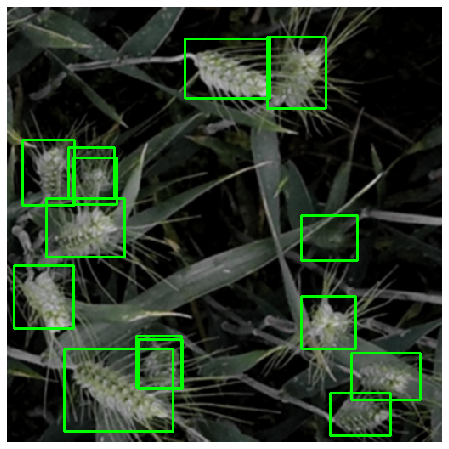

In [16]:
def sample_draw():

    dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] == 0].index.values,
        marking=marking,
        transforms=get_train_transforms(),
        test=False,
    )


    image, target, image_id = dataset[6]
    boxes = target['boxes'].cpu().numpy().astype(np.int32)

    numpy_image = image.permute(1,2,0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)

    ax.set_axis_off()
    ax.imshow(numpy_image);

sample_draw()

## Fitter

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
            logger.info(f'{self.base_dir} is created')
            
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as stdout_logger:
            stdout_logger.write(f'{message}\n')
        logger.info(message)

In [19]:
class TrainGlobalConfig:
    def __init__(self, 
                 num_workers = 2,
                 batch_size = 4,
                 n_epochs = 40, 
                 lr = 0.0002, 
                 folder = 'effdet5-cutmix-mixup-CV', 
                 verbose = True, 
                 verbose_step = 1,
                 step_scheduler = False,
                 validation_scheduler = True,
                ):
        self.num_workers = num_workers
        self.batch_size = batch_size 
        self.n_epochs = n_epochs
        self.lr = lr 
        self.folder = folder

        # -------------------
        self.verbose = verbose
        self.verbose_step = verbose_step
        # -------------------

        # --------------------
        self.step_scheduler = step_scheduler  # do scheduler.step after optimizer.step
        self.validation_scheduler = validation_scheduler  # do scheduler.step after validation stage loss

    #     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    #     scheduler_params = dict(
    #         max_lr=0.001,
    #         epochs=n_epochs,
    #         steps_per_epoch=int(len(train_dataset) / batch_size),
    #         pct_start=0.1,
    #         anneal_strategy='cos', 
    #         final_div_factor=10**5
    #     )

        self.SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
        self.scheduler_params = dict(
            mode='min',
            factor=0.5,
            patience=2, # 重要なハイパラ
            verbose=False, 
            threshold=0.0001,
            threshold_mode='abs',
            cooldown=0, 
            min_lr=1e-8,
            eps=1e-08
        )
        # --------------------

In [20]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()



In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [22]:
'''
def run_training(fold_num, net, train_global_config):
    device = torch.device('cuda:0')
    net.to(device)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_global_config.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=train_global_config.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=train_global_config.batch_size,
        num_workers=train_global_config.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)
'''

"\ndef run_training(fold_num, net, train_global_config):\n    device = torch.device('cuda:0')\n    net.to(device)\n    \n    train_loader = torch.utils.data.DataLoader(\n        train_dataset,\n        batch_size=train_global_config.batch_size,\n        sampler=RandomSampler(train_dataset),\n        pin_memory=False,\n        drop_last=True,\n        num_workers=train_global_config.num_workers,\n        collate_fn=collate_fn,\n    )\n    val_loader = torch.utils.data.DataLoader(\n        validation_dataset, \n        batch_size=train_global_config.batch_size,\n        num_workers=train_global_config.num_workers,\n        shuffle=False,\n        sampler=SequentialSampler(validation_dataset),\n        pin_memory=False,\n        collate_fn=collate_fn,\n    )\n\n    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)\n    fitter.fit(train_loader, val_loader)\n"

In [23]:
for fold_num in range(5):
    logger.info(f"{fold_num} fold start")
    # train config
    train_global_config = TrainGlobalConfig(n_epochs=1, folder = f'effdet5-cutmix-mixup-CV{fold_num}')
    
    # dataset
    dataset_dict = get_dataset(fold_num)
    train_dataset = dataset_dict['train']
    validation_dataset = dataset_dict['valid']
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_global_config.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=train_global_config.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=train_global_config.batch_size,
        num_workers=train_global_config.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )
    
    # net
    device = torch.device('cuda:0')
    net = get_net()
    net.to(device)
    
    fitter = Fitter(model=net, device=device, config=train_global_config)
    fitter.fit(train_loader, val_loader)
    
    logger.info(f"{fold_num} fold finished")
    

[INFO] 2020-07-24 16:10:17,488 >>0 fold start
INFO:effdet-mixup-cutmix-cv:0 fold start
[INFO] 2020-07-24 16:10:21,520 >>Fitter prepared. Device is cuda:0
INFO:effdet-mixup-cutmix-cv:Fitter prepared. Device is cuda:0
[INFO] 2020-07-24 16:10:21,522 >>
2020-07-24T07:10:21.521835
LR: 0.0002
INFO:effdet-mixup-cutmix-cv:
2020-07-24T07:10:21.521835
LR: 0.0002


Fitter prepared. Device is cuda:0

2020-07-24T07:10:21.521835
LR: 0.0002


RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 10.91 GiB total capacity; 4.67 GiB already allocated; 17.19 MiB free; 4.68 GiB reserved in total by PyTorch)

### Thank you for reading my kernel!

So, I have prepared good training SOTA-model baseline for you, my friends! I have used n_epochs = 40 and have got best checkpoint single model that gives 0.7176 LB. You can see [here](https://www.kaggle.com/shonenkov/inference-efficientdet) inference kernel.

Just recently I have started publishing my works, if you like this format of notebooks I would like continue to make kernels.